In [136]:
%load_ext nb_black
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats("png")
plt.style.use("seaborn-white")
import numpy as np
import seaborn as sns
from IPython.display import SVG

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Lecture 4

Ewen's sampling formula has one parameter $\theta$. What is $\theta$ and how do we estimate it?

Let $K_n=\sum_{i=1}^n a_i$ be the number of different alleles found in the sample.

**Theorem**. $\mathbb{E}K_n \sim \theta \log n$ and $\operatorname{Var} K_n \sim \theta \log n$.

Here, I used the notation $\sim$ to "asymptotic to", i.e. $a_n\sim b_n \iff \lim_n a_n / b_n = 1$.

*Proof*. Thinking back to Hoppe's urn, $K_n$ is the number of times that we add a new colored ball. Let $\eta_i=1$ if the $i$th ball added is of a new color, so $$\mathbb{E}K_n=\sum_{i=1}^n \mathbb{E} \eta_i = \sum_{i=1}^n \mathbb{P}(\eta_i=1).$$

From the definition of the urn, we know that $\mathbb{P}(\eta_i=1)=\theta/(\theta+i-1)$. Thus, $$\mathbb{E}K_n = \theta \sum_{i=1}^n \frac{1}{\theta+i-1}.$$ This sum is  $$\approx \int_\theta^{\theta+n}\frac{dx}{x} = \log(\theta+n)-\log(\theta) \sim \log n.$$



The variance computation is similar: since the $\eta_i$ are independent,
$$\operatorname{Var}K_n = \sum_{i=1}^n \operatorname{Var}\eta_i = \theta \sum_{i=1}^n \frac{i-1}{(\theta+i-1)^2}=\theta \sum_{i=1}^n \frac{1}{\theta+i-1}[1+o(1)],$$
so $\operatorname{Var}K_n \sim \theta \log n$ as well.

## Watterson's estimator

Hence, $K_n/\log n$ is an unbiased estimator of $\theta$, known as *Watterson's* estimator after its discoverer  and in fact it's asymptotically normal (by the Lindeberg-Feller CLT). But the asymptotic s.d. of $K_n/\log n$ is $1/\sqrt{\log n}$, which is much larger than the $1/\sqrt{n}$ rate we would like.

$K_n$ is a moment estimator. You might think we could do better by using the full distribution of $\mathbf{a}$, i.e. by maximizing $\mathbb{P}_\theta(\mathbf{a})$ using Ewen's formula. However, it turns out that $K_n$ is sufficient for $\theta$, so $\mathbf{a}$ contains no additional information about $\theta$ once you condition on its sum. See Durrett §1.3.2 for details.

## Estimating $\theta$ in humans
Now we are going to estimate $\theta$ using real data on humans. Recall from the last lecture that $\theta/2$ is the rate at which mutations occur in our coalescent process. Since we are scaling time in units of $2N$, where $N$ is the population size, we have that $\theta/2 = 2N\mu$, where $\mu$ is the number of mutations that occur each generation. From other biological evidence, we know that $\mu \approx 1.25\times 10^{-8}$ per nucleotide. So, by estimating $\theta$, we can estimate $\hat{N} = \hat{\theta} / (4 \times \mu)$.

In the process of estimating $\theta$, we will learn how to load and examine human data.
The data set we will use is a great resource called the [1000 Genomes Project](https://www.internationalgenome.org). This is a public dataset of almost 3,000 genomes collected from people around the world.

### The raw data
For our purposes, the raw data consists of the gene sequences for each person, something like this:

    > JonathanTerhorst ACGTGCAGTGCTAGCAGCATGACCTTA...
    > CalebKi          ACGTGCAGTGCTAGCAGCGTGACCTTA...
    > EnesDilber       ACGTGCCGTGCAAGCAGCCTGACCTTA...
    > RogerFederer     ACGTGCAGTGCAAGCAGCATGACCTTA...
    
Each string would have about 3.3 billion characters.

However, this is a very wasteful way to represent the data. You'll notice that the sequences are all identical except in a few positions. In real data, people are only different in about 1 out of every 1,000 positions. So we're 99.9% genetically similar.

For this reason, scientists have created a human ["reference" sequence](https://www.ncbi.nlm.nih.gov/genome/guide/human/), which is a "typical" sequence share by most humans. To exchange data, we just need to track the differences (called *variants*) between an individual genome and the reference sequence.

### Aside: Reference bias
The original human reference sequence was created from 13 anonymous donors living in Buffalo, NY, with most of it coming from one person. So, the reference sequence is biased towards people of European ancestry. This has created equity issues in genetics. For example, bioinformatics tools which rely on the reference sequence don't work as well when applied to data from people of African descent. See for example [this paper](https://www.nature.com/articles/s41588-018-0273-y).

### VCF format
The predominant method for exchanging genetic data is the VCF format. Essentially this a big tab-separated spreadsheet. Each row corresponds to a genetic variant, and the columns contain metadata, plus the genotypes of the samples.

Here is one row of the data:

In [1]:
import cyvcf2

v = next(cyvcf2.VCF("na12878.bcf"))
print(v)
print(f"chrom:{v.CHROM} ref:{v.REF} alt:{v.ALT} gts:{v.genotypes}")

1	100000012	rs10875231	G	T	100	PASS	AC=0;AF=0.301118;AN=2;NS=2504;DP=17508;EAS_AF=0.3224;AMR_AF=0.2478;AFR_AF=0.3691;EUR_AF=0.2465;SAS_AF=0.2812;AA=G|||;VT=SNP	GT	0|0

chrom:1 ref:G alt:['T'] gts:[[0, 0, True]]


## A better format
VCF is a legacy format which is somewhat inefficient. To represent all the data for a chromosome takes:

In [168]:
!ls -lh /scratch/1kg/bcfs/ALL.chr1.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.bcf

-rw-rw-r-- 1 terhorst research 1007M Aug 10 12:48 /scratch/1kg/bcfs/ALL.chr1.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.bcf


<IPython.core.display.Javascript object>

Instead, we will use a different recent format called a 'tree sequence' which compactly stores the data.

In [169]:
# !pip install tskit
# !wget https://zenodo.org/record/3051855/files/1kg_chr1.trees.tsz
# !tsunzip 1kg_chr1.trees.tsz

<IPython.core.display.Javascript object>

In [170]:
import tskit

chr1 = tskit.load("1kg_chr1.trees")

<IPython.core.display.Javascript object>

`chr1` contains all the genetic variation data for chromosome one in ~2500 people:

In [171]:
chr1.get_sample_size()

5008

<IPython.core.display.Javascript object>

It also contains all the metadata for individuals:

In [172]:
import json

next(
    ind
    for ind in chr1.individuals()
    if json.loads(ind.metadata)["individual_id"] == "NA12878"
)

{'id': 1752, 'flags': 0, 'location': array([], dtype=float64), 'metadata': b'{"family_id": "1463", "gender": "2", "individual_id": "NA12878", "maternal_id": "NA12892", "other_comments": null, "paternal_id": "NA12891", "phenotype": null, "relationship": "mother; child", "second_order": null, "siblings": null, "third_order": null}', 'nodes': array([3504, 3505], dtype=int32)}

<IPython.core.display.Javascript object>

### Watterson's estimator for `chr1`
According to the above result, our estimate for $\theta$ is the number of alleles $K_n$ divided by the ($\log$) of the sample size. What constitutes an allele here? Since the chromosome is very large and mutations are very sparse, each new mutation lands at a new site and creates a new allele. So we can approximate $K_n$ by the number of sites with mutations:

In [173]:
theta_W = (
    chr1.get_num_sites() / np.log(chr1.get_sample_size()) / chr1.get_sequence_length()
)
theta_W

0.00143839946639681

<IPython.core.display.Javascript object>

This gives an estimate of 

In [174]:
theta_W / (4 * 1e-8)

35959.98665992025

<IPython.core.display.Javascript object>

for the population size of humans. What's going on?

### Effective population size
If we think back to the Wright-Fisher model, we saw that the expected TMRCA between any two genes in the population was $2N$:

$$\mathbb{E}T_\text{MRCA} = 2N.$$

If we turn this relationship on its head, we get that 

$$N = \frac{1}{2\mathbb{E}T_\text{MRCA}}.$$

This relationship assumes a neutral, constant population size model. What sorts of things could cause it to break down?

Motivated by these phonemona, we define the *effective population size* $N_e$ to satisfy $N_e = 1/(2\mathbb{E}T_{\text{MRCA}})$. Note that this is different from the "census" population size (the number of people currently living). $N_e$ is always smaller than the census population size.

To investigate this further, we'll use simulation software to see how $N_e$ changes in various scenarios.

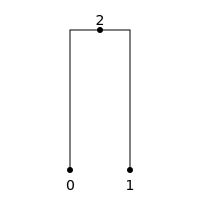

<IPython.core.display.Javascript object>

In [175]:
import msprime as msp

SVG(next(msp.simulate(sample_size=2).trees()).draw(format="svg"))

By default, $N_e=1$. So the height of the trees should be $2N_e=2$ on average:

In [176]:
np.mean([r.get_time(2) for r in msp.simulate(sample_size=2, num_replicates=1000)])

2.0230876286886823

<IPython.core.display.Javascript object>

We know that humans expanded rapidly in the very recent past, but before that they had a small effective population size:
![human Ne](https://www.genetics.org/content/genetics/205/1/385/F2.large.jpg?width=800&height=600&carousel=1)
Source: https://www.genetics.org/content/205/1/385

Let's use msprime to study the effect of population growth on $N_e$. To do this we need to define a series of demographic events. We'll use a simple approximation to the above plot:

In [177]:
g = 30  # generation time of humans
demographic_events = [
    msp.PopulationParametersChange(time=0, initial_size=1_000_000),
    msp.PopulationParametersChange(time=10_000 / g, initial_size=10_000),
    msp.PopulationParametersChange(time=100_000 / g, initial_size=40_000),
]

<IPython.core.display.Javascript object>

In [178]:
np.mean(
    [
        r.get_time(2)
        for r in msp.simulate(
            sample_size=2, num_replicates=1000, demographic_events=demographic_events
        )
    ]
) / 2

38791.86607044677

<IPython.core.display.Javascript object>

## Another estimator of $\theta$
There are other unbiased estimators of $\theta$. Given a sample of $n$ genes let $\pi_{ij}$ be the number of differences between them. For example:

In [179]:
sim = msp.simulate(sample_size=10, length=100, mutation_rate=0.002, random_seed=1)
G = sim.genotype_matrix()
G

array([[1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=int8)

<IPython.core.display.Javascript object>

The matrix G has one column per sample, and one row for each mutation.

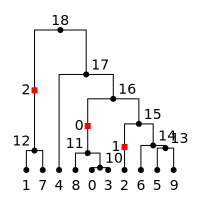

<IPython.core.display.Javascript object>

In [180]:
SVG(next(sim.trees()).draw("svg"))

The pairwise mismatches between any two samples is:

In [181]:
sum(abs(G[0] - G[1]))

4

<IPython.core.display.Javascript object>

It's easy to see that $\mathbb{E}\pi_{ij} = \theta$. Thus, $$\theta_\pi = \binom{n}{2}^{-1}\sum_{i\neq j} \pi_{ij}$$ is another unbiased estimator of $\theta$. This is known an *Tajima's $\pi$*. 

$\theta_\pi$ and $\theta_W$ are only equal in expectation when they are estimated from data that was generated under the neutral coalescent with constant population size. Tajima exploited this by looking at $D=\theta_W - \theta_\pi$. This can be used to detect patterns of natural selection and population expansion, which we will cover in a later lecture.